In [1]:
from qaravan.core import brickwall_skeleton, two_local_circ, set_style, TFI, RunContext
from qaravan.tensorQ import StatevectorSim
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define the problem
n = 4
ham = TFI(n)
true_ge, true_gs = ham.ground()  # uses Lanczos-based ED
print(f"True ground state energy: {true_ge}")

ham_mat = ham.matrix(dense=True) # PyTorch doesn't support sparse matrices yet
ham_mat = torch.tensor(ham_mat, dtype=torch.complex128)  # convert to PyTorch for AD

def circuit_energy(params, skeleton, ham_mat): 
    circ = two_local_circ(skeleton, params)
    sim = StatevectorSim(circ, backend="torch")
    sim.run(progress_bar=False)
    ansatz_sv = sim.get_statevector()
    return (ansatz_sv.conj() @ ham_mat @ ansatz_sv).real

True ground state energy: [-0.75]


In [3]:
# set up ansatz and optimizer 
num_layers = 1
skeleton = brickwall_skeleton(n, num_layers)  # structure of the ansatz circuit
params = torch.nn.Parameter(torch.randn(15*len(skeleton)))
optimizer = torch.optim.Adam([params], lr=0.05)

# set up RunContext for logging, checkpointing, and stopping
context = RunContext(
    progress_interval=10,
    max_iter=10000,
    checkpoint_file="checkpoint.pickle",
    checkpoint_interval=100,
    resume=False,
    convergence_check=True,
    stop_ratio=1e-8
)

# initialize the state of the run
cost_list = []
run_state = {
    "cost_list": cost_list,
    "step": context.step
}

while True:
    cost = circuit_energy(params, skeleton, ham_mat)
    cost_list.append(cost.item())
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # Update run state
    run_state["step"] += 1
    run_state["cost_list"] = cost_list

    # Let RunContext handle logging, checkpointing, and stopping
    if context.step_update(run_state):
        print(f"Terminating at step {run_state['step']} with cost {cost_list[-1]}")
        break

Step 10 at 2025-05-05T09:38:08 with cost -0.5784239737260337
Step 20 at 2025-05-05T09:38:09 with cost -0.722134483760944
Step 30 at 2025-05-05T09:38:09 with cost -0.7472103323440612
Step 40 at 2025-05-05T09:38:09 with cost -0.7471408218901043
Step 50 at 2025-05-05T09:38:10 with cost -0.7483018727908944
Step 60 at 2025-05-05T09:38:10 with cost -0.749452894306422
Step 70 at 2025-05-05T09:38:10 with cost -0.7497091742345836
Step 80 at 2025-05-05T09:38:10 with cost -0.7498749271845199
Step 90 at 2025-05-05T09:38:11 with cost -0.7499164597233186
Step 100 at 2025-05-05T09:38:11 with cost -0.7499560967100463
[Checkpoint saved at step 100]
Step 110 at 2025-05-05T09:38:11 with cost -0.7499693223072017
Step 120 at 2025-05-05T09:38:11 with cost -0.7499791398830259
Step 130 at 2025-05-05T09:38:12 with cost -0.7499854140554337
Step 140 at 2025-05-05T09:38:12 with cost -0.7499890019093802
Step 150 at 2025-05-05T09:38:12 with cost -0.7499921433364647
Step 160 at 2025-05-05T09:38:12 with cost -0.74999

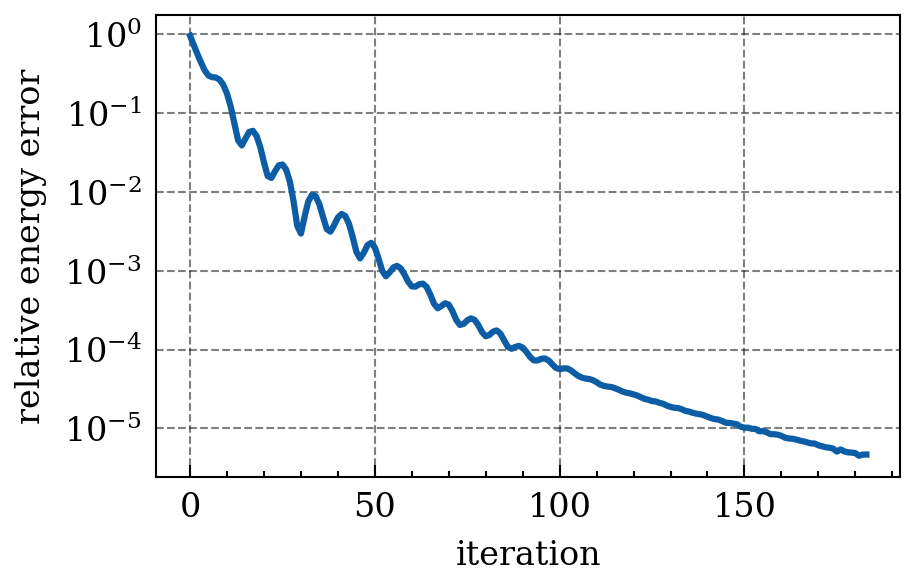

In [4]:
rel_energy_err = [np.abs(c-true_ge)/np.abs(true_ge) for c in cost_list]

set_style()
fig, ax = plt.subplots(figsize=(3.2,2))
ax.plot(rel_energy_err, label="Relative energy error", color="C0")
ax.set_xlabel("iteration")
ax.set_ylabel("relative energy error")
ax.set_yscale("log")